In [1]:
%reload_ext autoreload
#!pip install -r requirements.txt

64 torch.Size([10, 50])


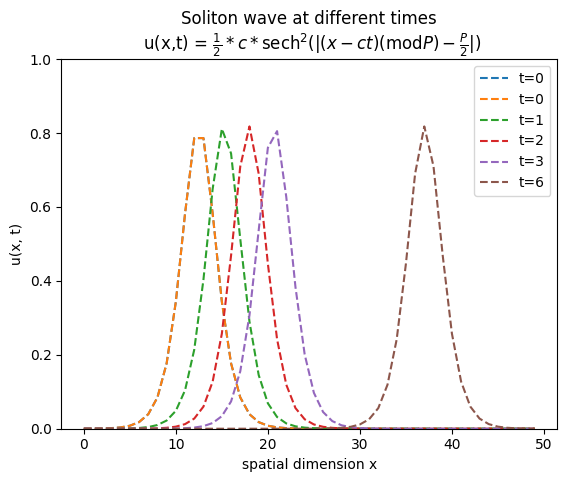

In [41]:
%autoreload
from architectures import COTGAN
from utils import DatasetSinus, DatasetSoliton, log_visualizations
from trainer import cotgan_trainer, cotgan_generator, create_dataset
from metrics import *
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

device = "cpu"

params_dataset = {
    "P": 20, # period
    "spatial_len": 50, # M
    "t_steps": 10,
    "t_range": [0, 6],
    "c_range": [0.5, 2],
}
trainset = create_dataset(dataset="soliton",n_samples=32*2, p=params_dataset, device=device)
testset  = create_dataset(dataset="soliton",n_samples=32*2, p=params_dataset)

print(len(testset), trainset[0].shape)

#plt.plot(trainset[0].T);
plt.plot(trainset[0][0].T, '--', label="t=0")

plt.plot(trainset[0][0].T, '--', label="t=0")
plt.plot(trainset[0][1].T, '--', label="t=1")
plt.plot(trainset[0][2].T, '--', label="t=2")
plt.plot(trainset[0][3].T, '--', label="t=3")
plt.plot(trainset[0][-1].T, '--', label="t=6")
plt.ylim(0, 1)
u_t_x = r"u(x,t) = $\frac{1}{2} *c* \mathrm{sech}^2 (| (x - c t) (\mathrm{mod}P)-\frac{P}{2}|)$"
plt.title(f"Soliton wave at different times\n {u_t_x}")
plt.xlabel("spatial dimension x")
plt.ylabel("u(x, t)")
plt.legend()

In [33]:
%autoreload
import neptune.new as neptune

run = neptune.init_run(
    project="kohmann/COTGAN",
    name="cotgan",
    tags=["soliton"],
    description="",
    source_files=["architectures.py"],
    capture_hardware_metrics=True,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

params = {
    "model_name": "model_cotgan.pt",
    "n_epochs": 100,
    "l_rate":   0.001, # for both D and G
    "l_rate_g": 0.001, # for G only
    "batch_size": 32,
    "use_opt_scheduler": False,

    "rnn_type": "GRU", # LSTM, GRU
    "dis_rnn_num_layers": 2,
    "dis_rnn_hidden_dim": 64,
    "gen_rnn_num_layers": 1,
    "gen_rnn_hidden_dim": 64,
    "J_dim": 30,
    "hidden_dim": 64, # generator: hidden dim in FC, discriminator: filters in Convolution
    "num_hidden_layers": 2, # generator fully-connected layers
    "use_bn": False, # batch normalization

    "scaling_coef": 1.0, # distance scaling (TODO(Not implemented))
    "reg_lam":      0.01, # martingale penalty coefficient
    "sinkhorn_eps": 10.0, # epsilon regularizer
    "sinkhorn_l":   100, # sinkhorn calculation iterations

    "Z_dim": 10,
    "optimizer": "Adam", # RMSprop, Adam
    "beta1": 0.5,
    "beta2": 0.9,
    "dataset": "soliton", # "soliton" or "sines"
    "feature_dim": trainset[0].size(1),
    "max_seq_len": trainset[0].size(0),
    "trainset_size": len(trainset),
    "testset_size": len(testset),
    "device": device,
}
params = params | trainset.get_params()
run["parameters"] = params
run["dataset"] = trainset.get_params()

model = COTGAN(params)
cotgan_trainer(model, trainset, params, val_dataset=testset, neptune_logger=run, continue_training=False)


# Generate random synthetic data
gen_z = cotgan_generator(model, params)

log_visualizations(testset, gen_z, run) # log pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload("./models/" + params["model_name"])

from metrics import compare_sin3_generation, sw_approx,two_sample_kolmogorov_smirnov, mae_height_diff

#np.random.seed(seed + 1)
#torch.manual_seed(seed + 1)

testset2 = create_dataset(dataset=params["dataset"], n_samples=params["testset_size"], p=params)
fake_data = cotgan_generator(model, params)

if params["dataset"] == "sines":
    mse_error = compare_sin3_generation(fake_data, 0.7, 0)
    print("ALPHA AND NOISE ARE HARD CODED IN THE METRIC FUNCTION to be 0.7 and 0.")
    run["numeric_results/sin3_generation_MSE_loss"] = mse_error

if params["dataset"] == "soliton":
    fake = torch.tensor(fake_data)
    c_fake = fake[:, 0,:].max(dim=1)[0]
    c_real = testset[:][:, 0,:].max(dim=1)[0]
    run["numeric_results/c_mode_collapse"] = two_sample_kolmogorov_smirnov(c_real, c_fake)
    run["numeric_results/height_diff_mae"] = mae_height_diff(fake)
    fig = plt.figure(figsize=(7, 5))
    plt.hist(2.*c_fake, bins=100, density=True)
    plt.xlim(0.5, 2)
    run["c_fake_distribution"].upload(fig)
    plt.close(fig)


n_samples = params["testset_size"]
max_seq_len = fake_data.shape[1]
x = torch.tensor(fake_data).view(n_samples * max_seq_len, -1)
y = testset[:].view(n_samples * max_seq_len, -1)
y_2 = testset2[:].view(n_samples * max_seq_len, -1)

run["numeric_results/num_test_samples"] = len(testset)
run["numeric_results/SW"] = sw_approx(y,x)
run["numeric_results/SW_baseline"] = sw_approx(y,y_2)
run.stop()


https://app.neptune.ai/kohmann/COTGAN/e/COT-242
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Epoch: 0, G: 104.8867, D: 104.2192:   0%|          | 0/10 [00:00<?, ?it/s]/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/COTGAN/trainer.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c_real = x_sw[:, 0, :].max(dim=1)[0]
Epoch: 9, G: 115.8246, D: 113.6906: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



Generating Data...Done
Real std:  [4.77454178e-02 1.05266205e-08]
Fake std:  [0.00152546 0.00077151]

Generating Data...Done
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 37 operations to synchronize with Neptune. Do not kill this process.
All 37 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/kohmann/COTGAN/e/COT-242


# RUN SINUS


--n_epochs 100 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset sinus --max_seq_len 25 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cpu

# RUN SOLITON

In [35]:
!python3 trainer.py --n_epochs 40 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset soliton --spatial_len 50 --t_steps 10 --P 20 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cuda

Traceback (most recent call last):
  File "/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/COTGAN/trainer.py", line 307, in <module>
    load_dataset_and_train(args)
  File "/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/COTGAN/trainer.py", line 176, in load_dataset_and_train
    trainset = create_dataset(dataset=params["dataset"],n_samples=params["trainset_size"], p=params, device=device)
  File "/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/COTGAN/trainer.py", line 164, in create_dataset
    return DatasetSoliton(n_samples=n_samples, spatial_len=p["spatial_len"], P=p["P"],
  File "/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/COTGAN/utils.py", line 183, in __init__
    self.data = self.data.to(device)
  File "/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/torch/cuda/__init__.py", line 221, in _lazy_init
    raise AssertionError("Torch not compiled with CUDA enabled")
AssertionError: Torch not compiled with CUDA enabled


In [36]:
!python3 trainer.py --n_epochs 40 --batch_size 32 --l_rate 0.001 --l_rate_g 0.001 --reg_lam 0.01 --sinkhorn_eps 0.8 --dataset soliton --spatial_len 50 --t_steps 10 --P 20 --trainset_size 1536 --testset_size 1536 --gen_rnn_num_layers 2 --gen_rnn_hidden_dim 64 --dis_rnn_num_layers 2 --dis_rnn_hidden_dim 64 --hidden_dim 64 --num_hidden_layers 3 --Z_dim 10 --J_dim 32 --device cpu

Num real train samples: 1536
Num real test  samples: 1536
https://app.neptune.ai/kohmann/COTGAN/e/COT-248
Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/
/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/venv/lib/python3.9/site-packages/neptune/new/handler.py:168: NeptuneDeprecationWarning: The object you're logging will be implicitly cast to a string. We'll end support of this behavior in `neptune-client==1.0.0`. To log the object as a string, use `str(object)` instead.
  self._container.define(self._path, value, wait)
Epoch: 0, G: 90.4097, D: 89.9076:   0%|                  | 0/40 [00:35<?, ?it/s]/Users/kohmann/Documents/Studie/2022 Høst/master-GAN/COTGAN/trainer.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fake = torch.te